In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
from matplotlib.lines import Line2D
import os
from pathlib import Path

# Memory spaces
- Global vs local memory
- Different strides between elements
- Read in global memory and write in:
    - Global mem
    - Local mem
- No computation

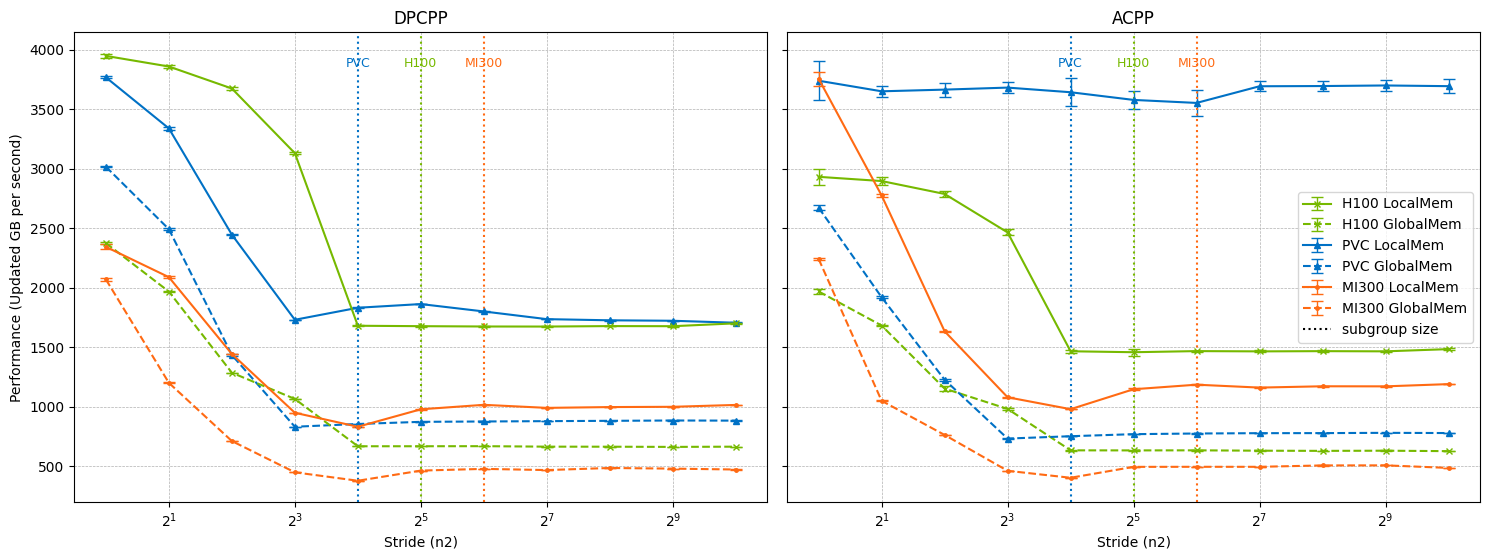

In [2]:


# Configuration
folder = "memory-spaces/"
compilers = ["dpcpp", "acpp"]
hardware_colors = {
    "h100": "#76B900",  # NVIDIA green
    "pvc": "#0071C5",   # Intel blue
    "mi300": "#FF6A13",
}

subgroup_sizes = {
    "h100": 32,   # NVIDIA warp
    "pvc": 16,    # Intel subgroup
    "mi300": 64
}

hardware_markers = {
    "h100": 'x',  # small cross
    "pvc": '^',   # triangle up
    # Add more markers here as needed
}

# Set up subplots: one per compiler
fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

for ax, compiler in zip(axes, compilers):
    file_pattern = f"{folder}/{compiler}_50_reps_*.json"
    json_files = glob.glob(file_pattern)

    all_strides = set()  # Collect all strides for proper x-axis ticks

    for filepath in json_files:
        hardware = os.path.splitext(os.path.basename(filepath))[0].split("_")[-1].lower()
        color = hardware_colors.get(hardware, 'gray')

        with open(filepath) as f:
            data = json.load(f)

        df = pd.DataFrame(data["benchmarks"])
        all_strides.update(df["n2"].unique())  # Collect strides

        means = df[df["aggregate_name"] == "mean"].copy()
        stddevs = df[df["aggregate_name"] == "stddev"].copy()

        merge_keys = ["run_name", "per_family_instance_index"]
        merged = pd.merge(
            means,
            stddevs[merge_keys + ["bytes_per_second"]],
            on=merge_keys,
            suffixes=("", "_stddev")
        )

        merged["mem_type"] = merged["name"].apply(lambda x: "LocalMem" if "LocalMem" in x else "GlobalMem")
        merged["stride"] = merged["n2"]
        merged["GBps"] = merged["bytes_per_second"] / 1e9
        merged["GBps_stddev"] = merged["bytes_per_second_stddev"] / 1e9

        for mem_type, style in [("LocalMem", "-"), ("GlobalMem", "--")]:
            subset = merged[merged["mem_type"] == mem_type].sort_values("stride")
            label = f"{hardware.upper()} {mem_type}"

            ax.errorbar(
                subset["stride"],
                subset["GBps"],
                yerr=subset["GBps_stddev"],
                capsize=4,
                elinewidth=1,
                label=label,
                linestyle=style,
                marker=hardware_markers.get(hardware, '.'),
                markersize=5,
                color=color
            )

    # Set log2 scale and base-10 stride labels
    all_strides = sorted(all_strides)
    ax.set_xscale("log", base=2)
    # ax.set_xticklabels([str(np.log2(x)) for x in all_strides])
    # ax.set_xticks(all_strides)
    ax.set_xlabel("Stride (n2)")
    ax.set_title(f"{compiler.upper()}")

    # Add subgroup size marker lines
    for hw, size in subgroup_sizes.items():
        if hw in hardware_colors:
            ax.axvline(x=size, color=hardware_colors[hw], linestyle=":", linewidth=1.5)
            ax.text(
                size, ax.get_ylim()[1] * 0.95,
                f"{hw.upper()}",
                color=hardware_colors[hw],
                ha="center", va="top", fontsize=9
            )

    ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Custom legend line for subgroup size marker
subgroup_legend = Line2D(
    [0], [0],
    color='black',
    linestyle=':',
    linewidth=1.5,
    label='subgroup size'
)
# Single legend on second subplot
axes[1].legend(handles=[*axes[1].get_legend_handles_labels()[0], subgroup_legend], loc="best")
# Shared Y label
axes[0].set_ylabel("Performance (Updated GB per second)")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("memory-spaces.pdf")
plt.show()


# Operations order

- Copy/solve vs solve/copy
- 2 applications with 2 sizes each (total elements 2**28):
    - conv1d
        - k=1, l=8192, c=1, n=32768
        - k=3, l=2048, c=4, n=32768
    - lag advection
        - n0=32768, n1=8192, n2=1
        - n0=1024, n1=8192, n2=32


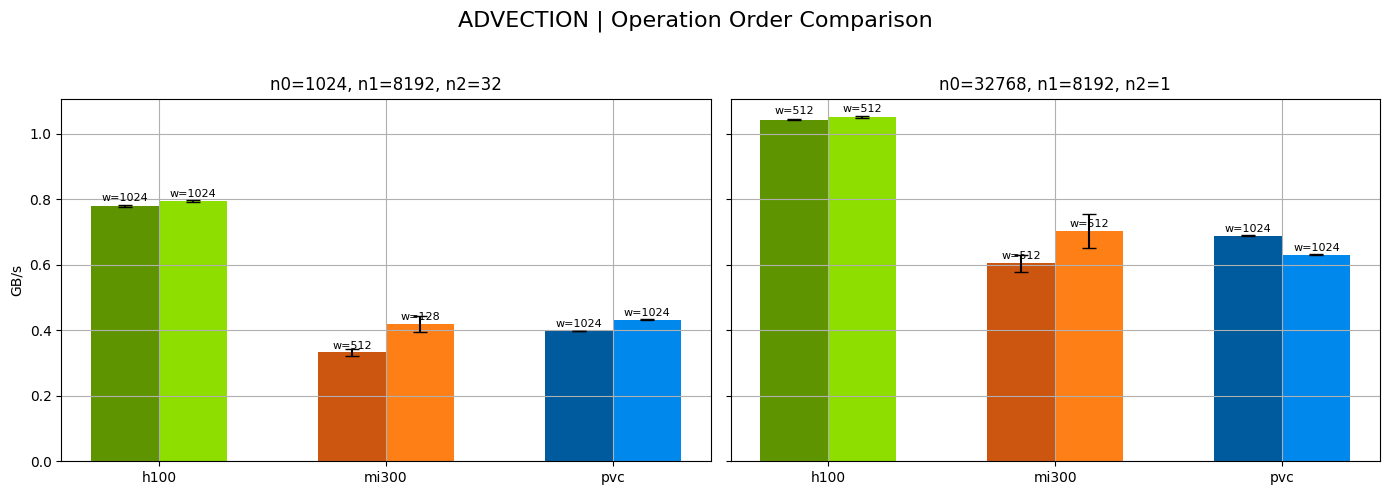

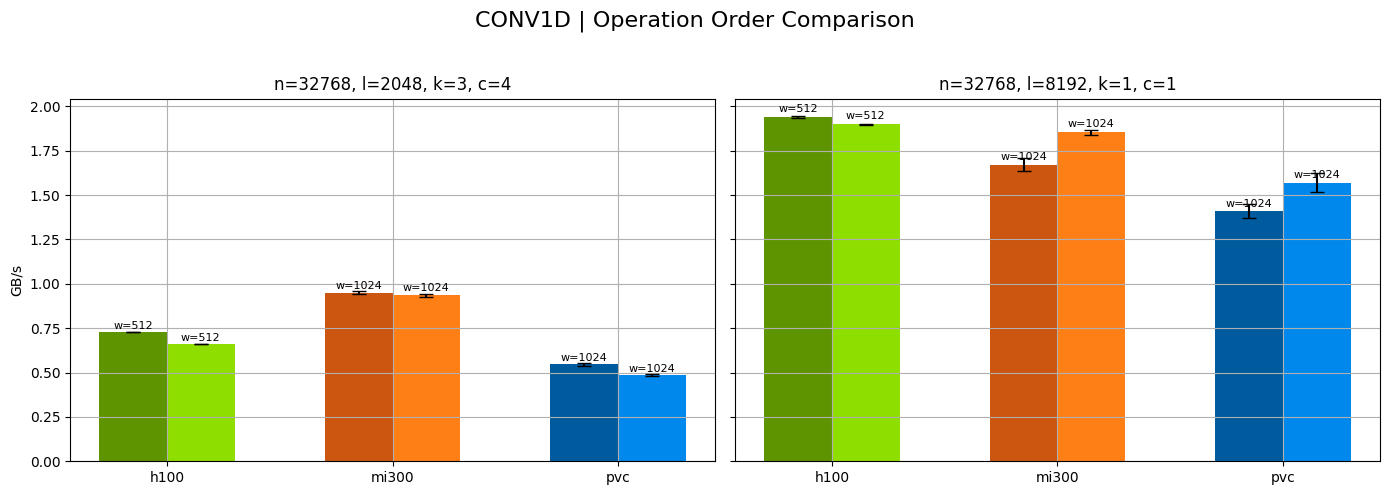

In [16]:
import os
import json
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from collections import defaultdict

# Constants
base_dir = Path("/home/ac.amillan/source/phd-experiments/out/op-order")
orders = ["copy_solve", "solve_copy"]
hardware_list = ['h100', 'mi300', 'pvc']
hardware_colors = {'h100': '#76B900', 'mi300': '#FF6A13', 'pvc': '#0071C5'}
order_factors = {'copy_solve': 0.8, 'solve_copy': 1.2}

def adjust_color_brightness(hex_color, factor=1.0):
    rgb = mcolors.to_rgb(hex_color)
    adjusted = [min(1, max(0, c * factor)) for c in rgb]
    return mcolors.to_hex(adjusted)

# Load and parse benchmark data
records = []
for order in orders:
    order_path = base_dir / order
    for file in order_path.glob("*.json"):
        parts = file.stem.split("_")
        if len(parts) != 3:
            continue
        app, hw, impl = parts
        IMPLS_=['dpcpp']
        if impl not in IMPLS_ or hw not in hardware_list:
            continue
        with open(file) as f:
            data = json.load(f)
            benchmarks = data["benchmarks"]
            grouped = defaultdict(dict)
            for b in benchmarks:
                if "aggregate_name" in b:
                    run_id = b.get("run_name", b.get("name"))
                    grouped[run_id][b["aggregate_name"]] = b
            for run, agg in grouped.items():
                if "mean" in agg and "stddev" in agg:
                    b_mean = agg["mean"]
                    b_std = agg["stddev"]
                    if app == "conv1d":
                        n = int(float(b_mean.get("batch_size", 0)))
                        l = int(float(b_mean.get("input_length", 0)))
                        k = int(float(b_mean.get("kernel_size", 0)))
                        c = int(float(b_mean.get("channels", 0)))
                        size_str = f"n={n}, l={l}, k={k}, c={c}"
                    else:
                        n0 = int(float(b_mean.get("n0", 0)))
                        n1 = int(float(b_mean.get("n1", 0)))
                        n2 = int(float(b_mean.get("n2", 0)))
                        size_str = f"n0={n0}, n1={n1}, n2={n2}"
                    records.append({
                        "app": app,
                        "size": size_str,
                        "hardware": hw,
                        "impl": impl,
                        "order": order,
                        "mean_bps": b_mean["bytes_per_second"],
                        "std_bps": b_std["bytes_per_second"],
                        "w": b_mean.get("pref_wg_size", None)
                    })

# Create DataFrame and keep best w per group
df = pd.DataFrame(records)
df = df.loc[df.groupby(["app", "size", "hardware", "impl", "order"])["mean_bps"].idxmax()]

if df.empty:
    print("No benchmark data found.")
else:
    for app in df["app"].unique():
        app_df = df[df["app"] == app]
        sizes = sorted(app_df["size"].unique())
        fig, axes = plt.subplots(1, len(sizes), figsize=(7 * len(sizes), 5), sharey=True)
        if len(sizes) == 1:
            axes = [axes]
        for ax, size in zip(axes, sizes):
            size_df = app_df[app_df["size"] == size]
            for i, hw in enumerate(hardware_list):
                for j, order in enumerate(orders):
                    row = size_df.query(f"hardware == '{hw}' and order == '{order}'")
                    if not row.empty:
                        row = row.iloc[0]
                        mean_val = row['mean_bps'] / 1e12
                        std_val = row['std_bps'] / 1e12
                        w_val = row['w']
                    else:
                        mean_val = 0
                        std_val = 0
                        w_val = None
                    color = adjust_color_brightness(hardware_colors[hw], order_factors[order])
                    xpos = i + j * 0.3 - 0.15
                    ax.bar(xpos, mean_val, yerr=std_val, width=0.3,
                           color=color, capsize=5)
                    if w_val is not None:
                        ax.text(xpos, mean_val + mean_val * 0.01, f"w={int(w_val)}",
                                ha='center', va='bottom', fontsize=8)
            ax.set_title(size)
            ax.set_xticks(range(len(hardware_list)))
            ax.set_xticklabels(hardware_list)
            ax.grid()

        axes[0].set_ylabel("GB/s")
        fig.suptitle(f"{app.upper()} | Operation Order Comparison", fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.savefig(f"operations-order-{app}.pdf")
        plt.show()


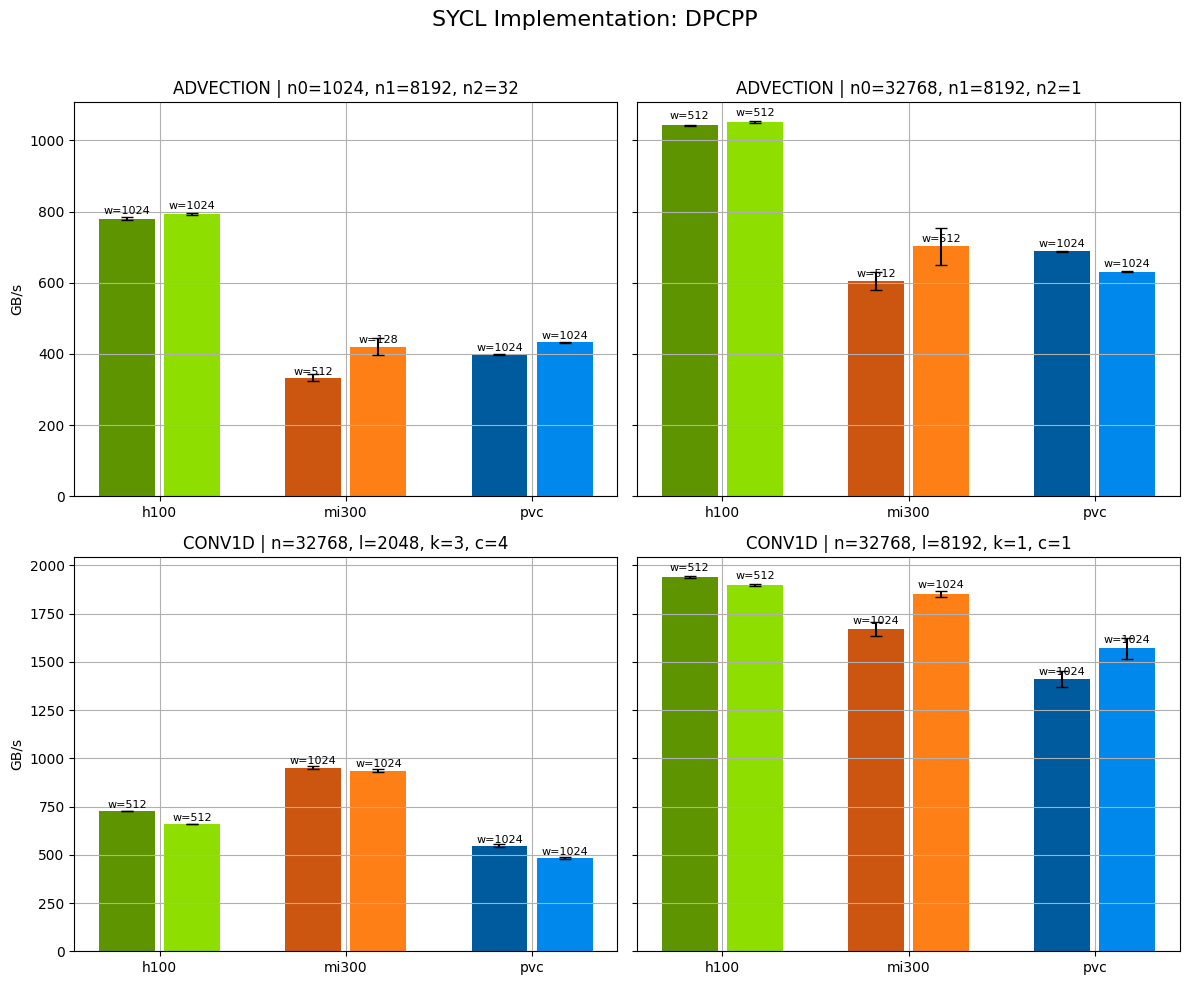

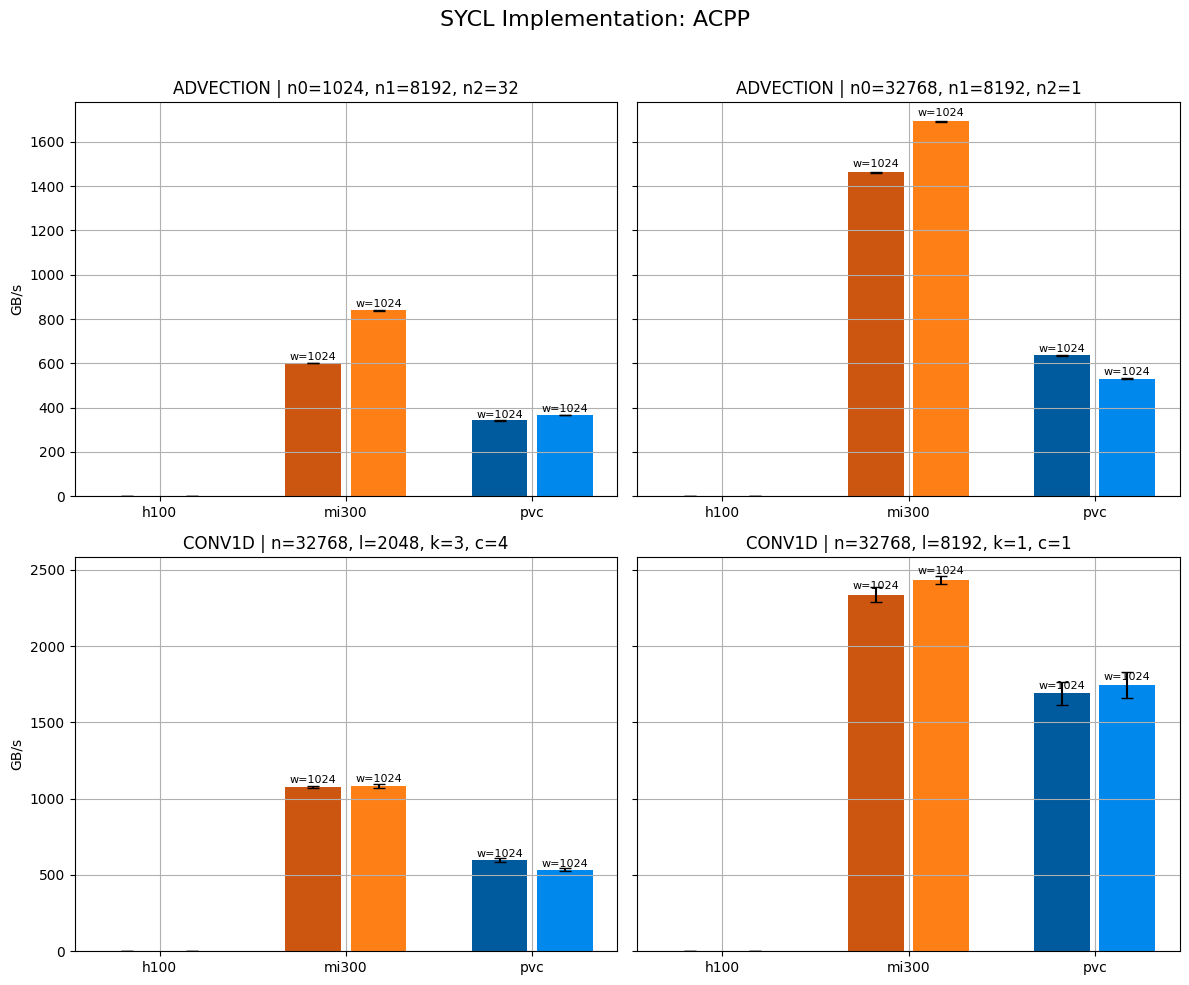

In [18]:
import os
import json
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from collections import defaultdict

# Constants
base_dir = Path("/home/ac.amillan/source/phd-experiments/out/op-order")
orders = ["copy_solve", "solve_copy"]
hardware_list = ['h100', 'mi300', 'pvc']
hardware_colors = {'h100': '#76B900', 'mi300': '#FF6A13', 'pvc': '#0071C5'}
order_factors = {'copy_solve': 0.8, 'solve_copy': 1.2}

def adjust_color_brightness(hex_color, factor=1.0):
    rgb = mcolors.to_rgb(hex_color)
    adjusted = [min(1, max(0, c * factor)) for c in rgb]
    return mcolors.to_hex(adjusted)

# Load and parse benchmark data
records = []
for order in orders:
    order_path = base_dir / order
    for file in order_path.glob("*.json"):
        parts = file.stem.split("_")
        if len(parts) != 3:
            continue
        app, hw, impl = parts
        if impl not in ['dpcpp', 'acpp'] or hw not in hardware_list:
            continue
        with open(file) as f:
            data = json.load(f)
            benchmarks = data["benchmarks"]
            grouped = defaultdict(dict)
            for b in benchmarks:
                if "aggregate_name" in b:
                    run_id = b.get("run_name", b.get("name"))
                    grouped[run_id][b["aggregate_name"]] = b
            for run, agg in grouped.items():
                if "mean" in agg and "stddev" in agg:
                    b_mean = agg["mean"]
                    b_std = agg["stddev"]
                    if app == "conv1d":
                        n = int(float(b_mean.get("batch_size", 0)))
                        l = int(float(b_mean.get("input_length", 0)))
                        k = int(float(b_mean.get("kernel_size", 0)))
                        c = int(float(b_mean.get("channels", 0)))
                        size_str = f"n={n}, l={l}, k={k}, c={c}"
                    else:
                        n0 = int(float(b_mean.get("n0", 0)))
                        n1 = int(float(b_mean.get("n1", 0)))
                        n2 = int(float(b_mean.get("n2", 0)))
                        size_str = f"n0={n0}, n1={n1}, n2={n2}"
                    records.append({
                        "app": app,
                        "size": size_str,
                        "hardware": hw,
                        "impl": impl,
                        "order": order,
                        "mean_bps": b_mean["bytes_per_second"],
                        "std_bps": b_std["bytes_per_second"],
                        "w": b_mean.get("pref_wg_size", None)
                    })

df = pd.DataFrame(records)
df = df.loc[df.groupby(["app", "size", "hardware", "impl", "order"])["mean_bps"].idxmax()]

if df.empty:
    print("No benchmark data found.")
else:
    for impl in df["impl"].unique():
        impl_df = df[df["impl"] == impl]
        apps = ["advection", "conv1d"]
        app_sizes = {app: sorted(impl_df[impl_df["app"] == app]["size"].unique()) for app in apps}

        # Layout: rows = apps, cols = max number of sizes
        max_cols = max(len(s) for s in app_sizes.values())
        fig, axs = plt.subplots(nrows=2, ncols=max_cols, figsize=(6 * max_cols, 10), sharey='row')
        if max_cols == 1:
            axs = axs.reshape(2, 1)

        for row_idx, app in enumerate(apps):
            sizes = app_sizes[app]
            for col_idx, size in enumerate(sizes):
                ax = axs[row_idx, col_idx]
                size_df = impl_df[(impl_df["app"] == app) & (impl_df["size"] == size)]
                for i, hw in enumerate(hardware_list):
                    for j, order in enumerate(orders):
                        row = size_df.query(f"hardware == '{hw}' and order == '{order}'")
                        if not row.empty:
                            row = row.iloc[0]
                            mean_val = row['mean_bps'] / 1e9
                            std_val = row['std_bps'] / 1e9
                            w_val = row['w']
                        else:
                            mean_val = 0
                            std_val = 0
                            w_val = None
                        color = adjust_color_brightness(hardware_colors[hw], order_factors[order])
                        xpos = i + j * 0.35 - 0.175
                        ax.bar(xpos, mean_val, yerr=std_val, width=0.3, color=color, capsize=4)
                        if w_val is not None:
                            ax.text(xpos, mean_val + mean_val * 0.01, f"w={int(w_val)}",
                                    ha='center', va='bottom', fontsize=8)
                ax.set_title(f"{app.upper()} | {size}")
                ax.set_xticks(range(len(hardware_list)))
                ax.set_xticklabels(hardware_list)
                ax.grid()

            # Hide unused columns if any
            for empty_col in range(len(sizes), max_cols):
                fig.delaxes(axs[row_idx, empty_col])

        axs[0, 0].set_ylabel("GB/s")
        axs[1, 0].set_ylabel("GB/s")
        fig.suptitle(f"SYCL Implementation: {impl.upper()}", fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.savefig(f"operations-order-structured-{impl}.pdf")
        plt.show()


# AdaptiveWg experiments

- 2 objectives to show:
    - no overhead compared to NDRange when d1 is contiguous
    - performance gain when d1 is non contiguous
- Only advection
- two sizes
    - n0=32768, n1=8192, n2=1
    - n0=1024, n1=8192, n2=32


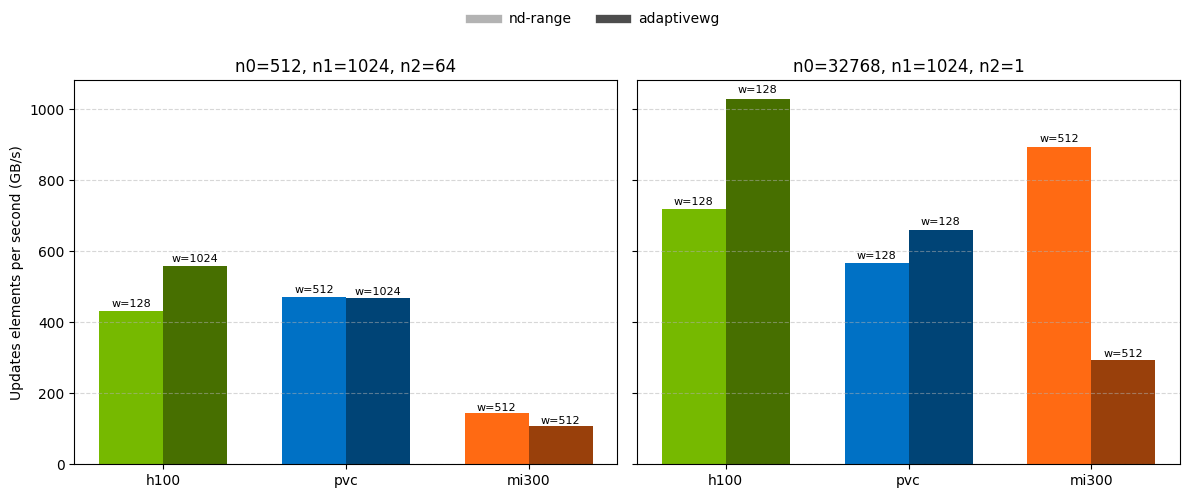

In [11]:
import json
import glob
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

# hardware color mapping
hw_colors = {
    'h100': '#76B900',
    'pvc': '#0071C5',
    'mi300': '#FF6A13'
}
shade_factor = 0.6

# load all JSONs in folder
data = []

for filepath in glob.glob('/home/ac.amillan/source/phd-experiments/out/adaptive_wg/advection_*_dpcpp.json'):
    fname = os.path.basename(filepath)
    hw = fname.split('_')[1]
    with open(filepath) as f:
        j = json.load(f)
    temp_data = []
    for b in j['benchmarks']:
        if b['aggregate_name'] == 'mean':
            temp_data.append({
                'hardware': hw,
                'n0': b['n0'],
                'n1': b['n1'],
                'n2': b['n2'],
                'kernel_id': int(b['kernel_id']),
                'bytes_per_second': b['bytes_per_second'],
                'stddev': None,
                'w': b.get('pref_wg_size', None)
            })
        elif b['aggregate_name'] == 'stddev':
            for entry in reversed(temp_data):
                if (entry['hardware'] == hw and
                    entry['n0'] == b['n0'] and
                    entry['n1'] == b['n1'] and
                    entry['n2'] == b['n2'] and
                    entry['kernel_id'] == int(b['kernel_id'])):
                    entry['stddev'] = b['real_time']
                    break
    data.extend(temp_data)

df = pd.DataFrame(data)
df = df.loc[df.groupby(['n0', 'n1', 'n2', 'hardware', 'kernel_id'])['bytes_per_second'].idxmax()]
sizes = df[['n0','n1','n2']].drop_duplicates().sort_values(['n0','n1','n2']).values

fig, axs = plt.subplots(1, len(sizes), figsize=(12, 5), sharey=True)

for ax, (n0, n1, n2) in zip(axs, sizes):
    df_size = df[(df.n0==n0) & (df.n1==n1) & (df.n2==n2)]
    hw_list = sorted(df_size['hardware'].unique(), key=lambda x: list(hw_colors).index(x))
    x = np.arange(len(hw_list))
    width = 0.35

    for i, hw in enumerate(hw_list):
        for k_id, offset in [(0, -width/2), (1, width/2)]:
            row = df_size[(df_size.hardware == hw) & (df_size.kernel_id == k_id)]
            if row.empty:
                continue
            row = row.iloc[0]
            y = row['bytes_per_second'] / 1e9
            yerr = row['stddev']
            w_val = row['w']
            base_color = hw_colors[hw]
            if k_id == 0:
                color = base_color
            else:
                rgb = np.array(mcolors.to_rgb(base_color))
                color = rgb * shade_factor
            ax.bar(x[i] + offset, y, width, color=color, yerr=yerr, capsize=3)
            ax.text(x[i] + offset, y + y * 0.01, f'w={int(w_val)}',
                    ha='center', va='bottom', fontsize=8)

    ax.set_xticks(x)
    ax.set_xticklabels(hw_list)
    ax.set_title(f'n0={int(n0)}, n1={int(n1)}, n2={int(n2)}')
    ax.grid(axis='y', linestyle='--', alpha=0.5)

axs[0].set_ylabel('Updates elements per second (GB/s)')

# Grayscale legend for kernel types
custom_lines = [
    plt.Line2D([0], [0], color='0.7', lw=6, label='nd-range'),
    plt.Line2D([0], [0], color='0.3', lw=6, label='adaptivewg')
]
fig.legend(handles=custom_lines, loc='upper center', ncol=2, frameon=False)

plt.tight_layout(rect=[0, 0, 1, 0.92])
fig.savefig("adaptivewg-vs-ndrange.pdf")